In [8]:
using Plots
using Statistics
using FFTW
using DSP

# Leaky Integrator

The goal of this notebook is to create a leaky integrator which smooths a signal. This can be used to relate signals with higher frequency components to signals with lower frequency components.

$$\tau \dot{v} = S-v$$

where S is the LFP signal.

General Solution:

$$v(t) = ke^{-t/\tau}+S$$

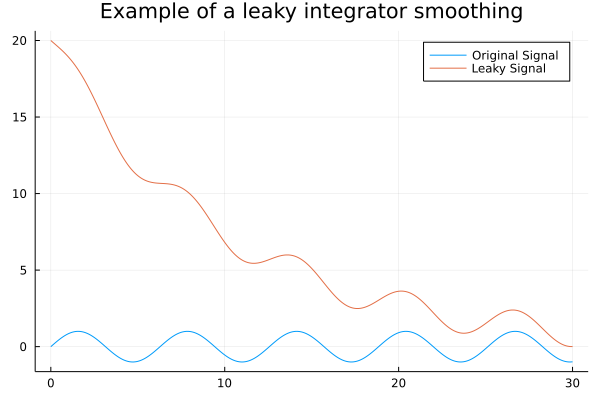

In [2]:
S(t) = sin(t)
k = 20
tau = 10
v(t) = k * exp(-t/tau) + S(t)

plot((0:0.01:30), S.((0:0.01:30)), label="Original Signal")
plot!((0:0.01:30), v.((0:0.01:30)), label="Leaky Signal")

title!("Example of a leaky integrator smoothing")

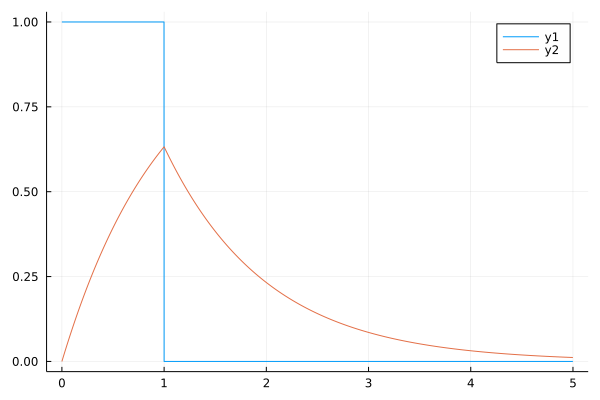

In [3]:
dt = .001
maxt = 5
t = 0:dt:(maxt-dt)
nt = length(t)

k=1

s  = cat(ones(div(length(t), 5)), zeros(4*div(length(t),5)); dims=1)

y = zeros(length(t));
for i in 1:(nt-1)
    dy = s[i]-y[i]/k;
    y[i+1] = y[i]+dy*dt;
end

plot(t,s)
plot!(t,y)

In [4]:
include("../helpers/importing.jl")
lfp = import_lfp("Exp 2/R7/2022-05-11_17-39-17/Record Node 113/")

Dict{String, Any} with 5 entries:
  "laser"      => Dict("off"=>[326750.0, 449113.0, 494635.0, 534317.0, 626549.0…
  "sync"       => Dict("off"=>[28499.0, 39004.0, 49509.0, 60014.0, 70519.0, 810…
  "oxygen"     => Dict("off"=>[], "on"=>[25998.0])
  "data"       => Float32[-0.494325 -0.418275 … 0.0 0.0; 0.3042 0.3042 … 0.0 0.…
  "timestamps" => [25800.0, 25801.0, 25802.0, 25803.0, 25804.0, 25805.0, 25806.…

In [9]:
# Compute the Fourier Transform
sampling_rate = 1000
freqs = fftfreq(length(lfp["data"][1,:]), sampling_rate)

# Butterworth's low pass filter equation
function butterworth_low(freq, pass_freq, n=5)
    return 1 / (1 + (abs(freq) / pass_freq) ^ 2n)
end

# Butterworth's high pass filter equation
function butterworth_high(freq, pass_freq, n=5)
    return 1 / (1 + (pass_freq / abs(freq)) ^ 2n)
end


# Apply the Band-Pass Butterworth filter
band = [1, 45]
lfp_envelopes = []
for i in 1:length(lfp["data"][:,1])
    F = fft(lfp["data"][i, :])
    for i in 1:length(F)
        F[i] = F[i] * butterworth_high(freqs[i], band[1]) * butterworth_low(freqs[i], band[2]) 
    end
    banded_lfp = real(ifft(F))
    push!(lfp_envelopes, abs.(hilbert(banded_lfp)))
end
lfp_envelopes

4-element Vector{Any}:
 Float32[0.32467264, 0.3369137, 0.34916317, 0.36133584, 0.37329996, 0.38487384, 0.39582816, 0.40589353, 0.4147755, 0.42217076  …  0.20723967, 0.2182314, 0.22951834, 0.24102773, 0.25270066, 0.26449305, 0.27637628, 0.28833723, 0.3003736, 0.31248626]
 Float32[0.49513575, 0.52582496, 0.5550777, 0.58230066, 0.60692, 0.62839276, 0.6462165, 0.65994716, 0.669209, 0.67371005  …  0.23544918, 0.2503873, 0.2686107, 0.29001296, 0.3143275, 0.34116834, 0.37006277, 0.4004825, 0.43186152, 0.46361288]
 Float32[0.19749568, 0.21455085, 0.23110318, 0.24689661, 0.26168612, 0.27524698, 0.28738058, 0.29792053, 0.30673748, 0.31374452  …  0.055105843, 0.06351372, 0.073792115, 0.085748576, 0.099168174, 0.11382689, 0.12949821, 0.14594753, 0.1629325, 0.18020171]
 Float32[0.04994625, 0.04945567, 0.057460155, 0.07289393, 0.093339995, 0.1170033, 0.14275755, 0.16983, 0.19761258, 0.22557646  …  0.098879606, 0.10024655, 0.100168236, 0.09849456, 0.095118366, 0.08999296, 0.08316825, 0.074859396, 0.0

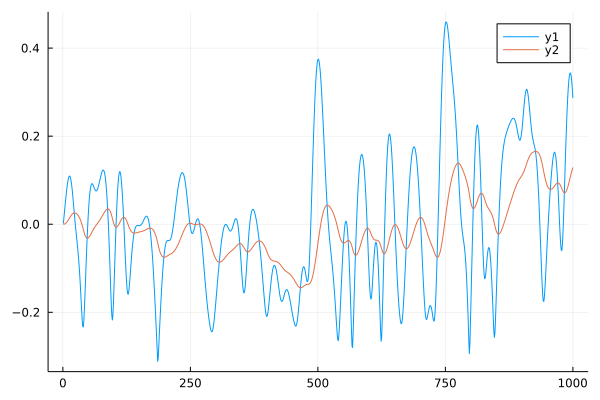

In [27]:
maxt = 1000
t = (1:maxt)
nt = length(t)

k=0.05

s = lfp_envelopes[1][t] .- mean(lfp_envelopes[1][t])

y = zeros(length(t));
for i in 1:(nt-1)
    dy = (s[i]-y[i])/k;
    y[i+1] = y[i]+dy*dt;
end

plot(t,s)
plot!(t,y)